##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#EPIDEEP: Generating EPID images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Colab Notebook heavily buroows from the pix2pix example. 
How to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.



## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import sys 
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp

In [ ]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive


Line to install pymedphys which has a gamma function. Libaray was saved to Google drive and is commented out.

In [ ]:
#!pip install --target=$nb_path pymedphys

In [ ]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 16.0 MB/s 
     |████████████████████████████████| 793 kB 59.6 MB/s 
     |████████████████████████████████| 381 kB 61.6 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import SimpleITK as sitk
import pymedphys

In [ ]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1094 (delta 44), reused 67 (delta 25), pack-reused 1006
Receiving objects: 100% (1094/1094), 524.55 KiB | 14.99 MiB/s, done.
Resolving deltas: 100% (690/690), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1271, done.        
remote: Counting objects: 100% (66/66), done.        
remote: Compressing objects: 100% (25/25), done.        
remote: Total 1271 (delta 36), reused 58 (delta 29), pack-reused 1205        
Receiving objects: 100% (1271/1271), 294.66 KiB | 9.21 MiB/s, done.
Resolving deltas: 100% (809/809), done.
Submodule path 'Image_Processors_Module': checked out '23dae05326dc1d320f4fa56c9163fe4a994aa

In [ ]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

In [ ]:
class ImageProcessor(object):
    def parse(self, *args, **kwargs):
        return args, kwargs
def _check_keys_(input_features, keys):
    if type(keys) is list or type(keys) is tuple:
        for key in keys:
            assert key in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                                 '{} was not found'.format(key)
    else:
        assert keys in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                              '{} was not found'.format(keys)
class DivideBasedOnOther(ImageProcessor):
    def __init__(self, guiding_keys=('annotation',), changing_keys=('image',)):
        self.guiding_keys, self.changing_keys = guiding_keys, changing_keys

    def parse(self, input_features, *args, **kwargs):
        _check_keys_(input_features=input_features, keys=self.guiding_keys)
        _check_keys_(input_features=input_features, keys=self.changing_keys)
        for guiding_key, changing_key in zip(self.guiding_keys, self.changing_keys):
            input_features[changing_key] = input_features[changing_key] / input_features[guiding_key]
        return input_features

In [ ]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=False, **kwargs):
  global_norm = False
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
                     CProcessors.Squeeze(image_keys=all_keys),
                     CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
                     CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                                          values=(1/90, 1/90, 1/90, 1/90)),
                     ]
  if global_norm:
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]
  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output',),
                                                output_keys=('fluence_array',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [ ]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset based on which fold you want to exclude

In [ ]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(batch_size)
  
  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)

  test_dataset = all_datasets['test']
  test_dataset = test_dataset.shuffle(len(test_dataset))
  test_dataset = test_dataset.batch(1)
  return train_dataset, valid_dataset, test_dataset

In [ ]:
def return_dataset(generator, batch):
  input_values = []
  output_values = []
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    input_values.append(x[0][0])
    output_values.append(y[0][0])
  input_dataset = tf.data.Dataset.from_tensor_slices(input_values)
  output_dataset = tf.data.Dataset.from_tensor_slices(output_values)
  dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
  dataset = dataset.shuffle(len(dataset)).batch(batch)
  return dataset

In [ ]:
def return_generators(base_path, excluded_fold=5, batch=1, **kwargs):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  test_folder_names = []
  #train_folder_names.append(os.path.join(base_path, 'phantom_train'))
  #val_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  #test_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  test_folder_names.append(os.path.join(base_path, 'pat6'))
  
  for i in range(1,6):
    folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
    if i != excluded_fold:
      train_folder_names.append(folder_name)
    else:
      val_folder_names.append(folder_name)
  
  train_gen = return_generator(train_folder_names, batch=1, **kwargs)
  train_gen = return_dataset(train_gen, batch)

  valid_gen = return_generator(val_folder_names, batch=1, **kwargs)
  valid_gen = return_dataset(valid_gen, 1)
  
  test_gen = return_generator(test_folder_names, batch=1, **kwargs)
  test_gen = return_dataset(test_gen, 1)
  
  return train_gen, valid_gen, test_gen

In [ ]:
batch = 1
base_path = '/content/drive/My Drive/data'
train_dataset, valid_dataset, test_dataset = return_generators(base_path, excluded_fold=1, batch=batch)

Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}


In [ ]:
iterx = iter(train_dataset.repeat())

520
138
10


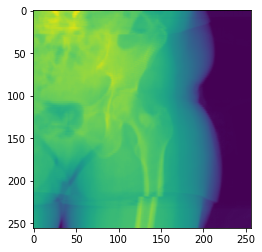

In [ ]:
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len =  len(test_dataset)
x, y = next(iterx)
print(train_len)
print(valid_len)
print(test_len)
plt.imshow(x[0,...,1])

In [ ]:
OUTPUT_CHANNELS = 1

You can inspect some of the preprocessed output:

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
#new_generator = Generator(size=4, layers=7, double_layers=4, filters_start=64)
# tf.keras.utils.plot_model(new_generator, show_shapes=True, dpi=64)

Visualize the generator model architecture:

In [ ]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
#generator.summary()

Test the generator:

In [ ]:
# print(tf.shape(inp))
# print(tf.shape(inp[tf.newaxis, ...]))

# gen_output = generator(inp[tf.newaxis, ...], training=False)
# #print(tf.shape(gen_output))
# plt.imshow(tf.squeeze(gen_output[0, ...],axis=-1))

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss( gen_output, target):
  
  
  # gamma = 0.5
  # #gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # sobel_target = tf.image.sobel_edges(target)
  # sobel_targety = sobel_target[...,0]
  # sobel_targetx = sobel_target[...,1]

  # sobel_gen_output = tf.image.sobel_edges(gen_output)
  # sobel_geny = sobel_gen_output[...,0]
  # sobel_genx = sobel_gen_output[...,1]
  # sobel_tar = tf.sqrt(tf.square(sobel_targetx) +  tf.square(sobel_targety))
  # sobel_gen = tf.sqrt(tf.square(sobel_genx) +  tf.square(sobel_geny))

  # loss_sobel = tf.reduce_mean(tf.abs(sobel_target - sobel_gen_output))
  # Mean absolute error
  #l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  #loss = l1_loss*(1-gamma) + loss_sobel*gamma
  #l1_loss = tf.reduce_mean(tf.square(target - gen_output))
  # w = 0.01
  # tar_bkg = tf.where(tf.less_equal(target,0.05),target,target-target)
  # gen_bkg = tf.where(tf.less_equal(gen_output,0.05),gen_output,gen_output-gen_output)


  # target_vals = tf.where(tf.greater(target,0.05),target,target-target)
  # gen_vals = tf.where(tf.greater(gen_output,0.05),gen_output,gen_output-gen_output)
  # #bkg = tf.where(tf.less_equal(target,-0.95),target-target,target)
  # l1_loss = w*tf.reduce_mean(tf.abs(tar_bkg - gen_bkg)) + tf.reduce_mean(tf.abs(target_vals - gen_vals))



  #total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  return  l1_loss

In [ ]:
def plot_images(prediction, input, target):
  plt.figure(figsize=(15, 10))

  # print("Input ")
  # print(type(cbct_input))
  # print(tf.shape(cbct_input))
  # print("ground truth")
  # print(type(tar))
  # print(tf.shape(tar))
  display_list = [ input[0], target[0], prediction[0] ]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']
  
  plt.subplot(1, 4, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.
  
  input = tf.squeeze(input,axis=0)
  inslice = input[...,1]
  
  plt.imshow(inslice)
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.title('Ground Truth')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(target[0],axis=-1))
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Predicted Image')
  plt.imshow(tf.squeeze(prediction))
  plt.axis('off')

  target = tf.squeeze(target)
  prediction = tf.squeeze(prediction)
  
  predvec = prediction[128,1:256]
  rtvec = target[128,1:256]
  

  plt.axis('off')
  plt.subplot(1, 4, 4)
  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')
  
  plt.show()

In [ ]:
import os
os.listdir('.')

['.config',
 'Data_Generators',
 'notebooks',
 'training_checkpoints',
 'drive',
 'sample_data']

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## Define the optimizers and a checkpoint-saver


In [ ]:
exp_loss = tf.keras.optimizers.schedules.ExponentialDecay(2e-4,decay_steps=20000,decay_rate=0.5)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(exp_loss, beta_1=0.9)

In [ ]:
!mkdir -p training_checkpoints
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/grad_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since
you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [ ]:
def generate_images(model, input, tar):
  prediction = model(input, training=True)
  plot_images(prediction, input, tar)

In [ ]:
val_iterator = iter(valid_dataset)

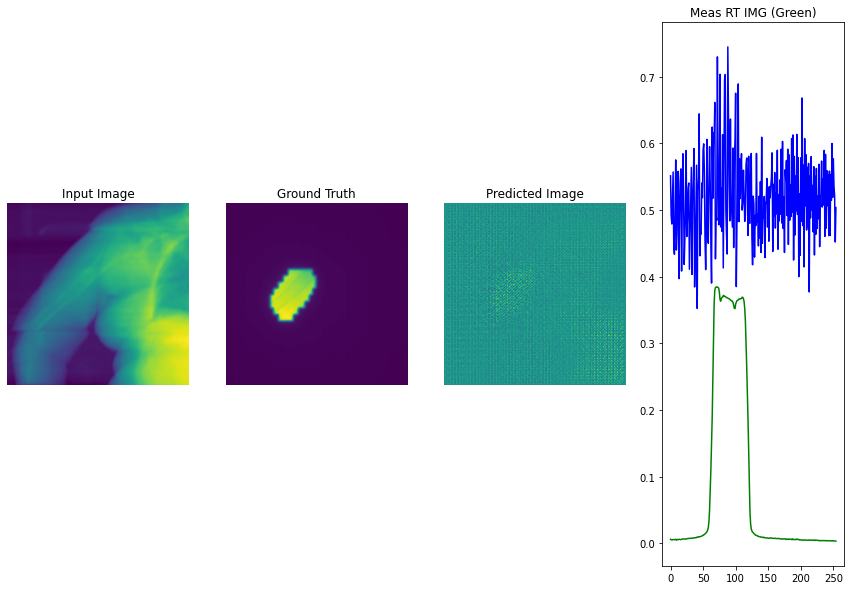

In [ ]:
x,y = next(val_iterator)
#pred = model.predict(x)
generate_images(generator, x, y)

Test the function:

In [ ]:
# for example in valid_dataset.take(1):
#   #input = example['input']
#   #print(tf.shape(input))
#   #rtimg = example['rtimg']
#   #rtimg = tf.squeeze(rtimg, axis=0)

#   generate_images(generator, input, rtimg)

In [ ]:
# sobel_target = tf.image.sobel_edges(rtimg)
# sobel_targety = sobel_target[...,0]
# sobel_targetx = sobel_target[...,1]

# #sobel_gen_output = tf.image.sobel_edges(gen_output)
# #sobel_geny = sobel_gen_output[...,0]
# #sobel_genx = sobel_gen_output[...,1]
# sobel_tar = tf.sqrt(tf.square(sobel_targetx) +  tf.square(sobel_targety))
# #tf.shape(sobel_target[...,1])
# tf.shape(sobel_tar)
# #tf.shape(rtimg)
# #sobtest = tf.squeeze(sobel_target[...,0],axis=-1)

# #plt.imshow(tf.squeeze(sobtest,axis=0))

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [ ]:
log_dir="/content/drive/MyDrive/Colab Notebooks/logs_phantom_grad/"
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

summary_writer = tf.summary.create_file_writer(
  log_dir + "patient_fold1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20220708-202934


In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    #disc_real_output = discriminator(target, training=True)
    #disc_generated_output = discriminator(gen_output, training=True)

    #disc_real_output = discriminator([input_image,target], training=True)
    #disc_generated_output = discriminator([input_image,gen_output], training=True)

    gen_l1_loss = generator_loss(gen_output, target)
    #disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_l1_loss,
                                          generator.trainable_variables)
  #discriminator_gradients = disc_tape.gradient(disc_loss,
  #                                            discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
  #                                            discriminator.trainable_variables))

  with summary_writer.as_default():
    #tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//500)
    #tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//500)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//train_len)
    #tf.summary.scalar('disc_loss', disc_loss, step=step//500)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  iterator = iter(test_ds.take(1))
  example = next(iterator)
  #x,y = next(val_iterator)
  #ex_input,rtimg = next(iterator)
  ex_input = example[0]
  rtimg = example[1]
  
  #rtimg = tf.squeeze(rtimg, axis=0)
  start = time.time()
  for step, (input_obj) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')
        start = time.time()

      generate_images(generator, ex_input, rtimg)
      print(f"Step: {step//1000}k")

    #input = input_obj['input']
    #target = input_obj['rtimg'] 
    input = input_obj[0]
    target = input_obj[1]
    train_step(input, target, step)

    # Training step
    if (step+1) % 100 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

Finally, run the training loop:

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
stop

NameError: ignored

In [ ]:
hund_epoch = 100*train_len
print(hund_epoch)

52000


Time taken for 1000 steps: 28.01559352874756 sec



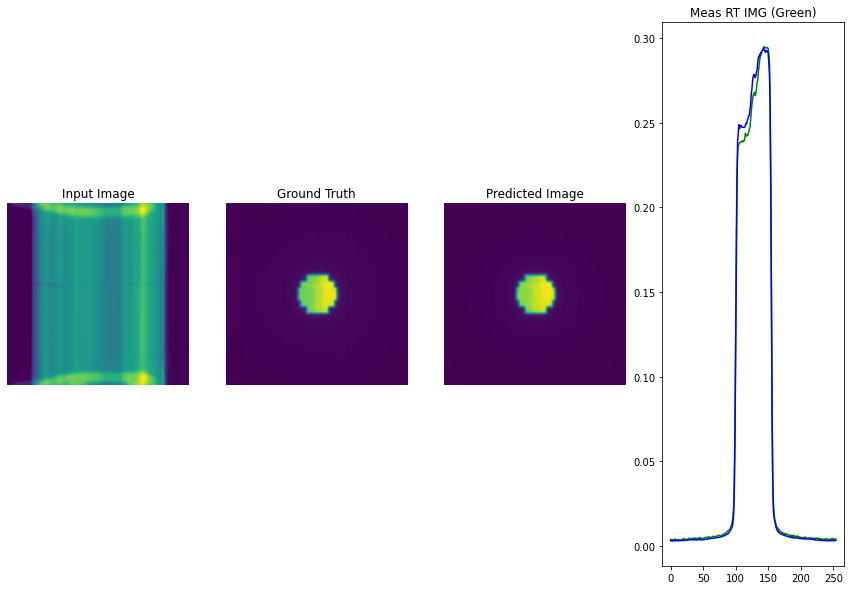

Step: 51k
..........

In [ ]:
fit(train_dataset, valid_dataset, steps=hund_epoch)

In [ ]:
#docs_infra: no_execute'
%reload_ext tensorboard
#%tensorboard --logdir /content/notebooks/logs/fit/

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs_phantom_grad/'

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
#os.listdir(checkpoint_dir)
#os.listdir(log_dir + '/fit')

In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)
#Restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/grad_checkpoints'
print(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#'/content/drive/MyDrive/Colab Notebooks/phantom_checkpoints/ckpt-8'

/content/drive/MyDrive/Colab Notebooks/grad_checkpoints/ckpt-10


## Generate some images using the test set

In [ ]:
#generator.save('/content/drive/MyDrive/Colab Notebooks/3chan_lrgken_L1')

In [ ]:
gamma_options = {
    'dose_percent_threshold': 3, 
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [ ]:
xepidmin = -215.04
xepidmax = 215.04
yepidmin = -215.04
yepidmax = 215.04
grid = 1.68
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

In [ ]:
# testfiles = tf.io.gfile.glob('/content/drive/My Drive/train/nifti/fold4/12_4_35.*')
# valid_data = load_data(testfiles, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')

# valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data))
# valid_dataset = valid_dataset.batch(BATCH_SIZE)

Calcing using global normalisation point for gamma
Global normalisation set to 0.32475489377975464
Global dose threshold set to [0.00974265] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.03247548937797547 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 54 | Points tested per reference point: 247 | RAM split count: 1
Complete!


Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 81.84 %')

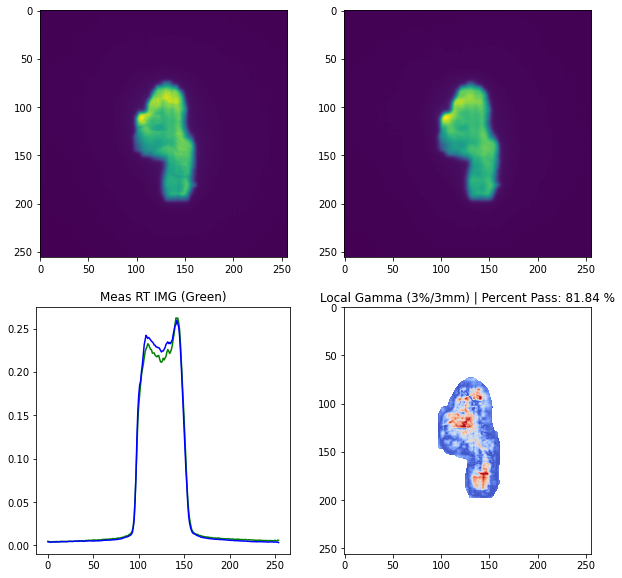

In [ ]:
example = next(iter(test_dataset))
input = example[0]
#print(tf.shape(cbct_input))
tar = example[1]
prediction = generator(input, training=True) 

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar

prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction
 
plt.figure(figsize=(10, 10))
  
plt.subplot(2, 2, 1)
plt.imshow(rtimage)
plt.subplot(2, 2, 2)
plt.imshow(prediction)
  
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]
  
#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]

plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'b')
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
plt.imshow(gamma_test)

In [ ]:
caxcb = [] 
caxrt = []
caxpred = []
caxhalf = []

all_ratios = np.zeros(len(list(valid_dataset)))

for example in valid_dataset:
  tinp = example[0]
  ttar = example[1]
  inp = tf.squeeze(tinp,axis=0)
  #slicen = 1
  pdos = getinput(inp,0)
  img = getinput(inp,1)
  half = getinput(inp,2)
  cbctcax = np.mean(img[126:130,126:130] )
  pdoscax = np.mean(pdos[126:130,126:130] )
  halfcax = np.mean(half[126:130,126:130] )
  prediction = generator(tinp, training=True)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar
  rtcax = np.mean(ttar[126:130,126:130])
  
  #out = "cbctcax {} rtcax {}".format(cbctcax,rtcax/pdoscax)
  #print(out)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  predcax = np.mean(prediction[126:130,126:130])
  caxcb = np.append(caxcb,cbctcax)
  caxrt = np.append(caxrt,rtcax/pdoscax)
  caxpred = np.append(caxpred,predcax/pdoscax)
  caxhalf = np.append(caxhalf,halfcax)

#ax = plt.axes(projection='3d')
#ax.scatter3D(caxcb, caxhalf, caxrt, c='b' )
#ax.scatter3D(caxcb, caxhalf, caxpred, c='r' )
#plt.show()

plt.plot(caxcb,caxrt,'bo')
plt.plot(caxcb,caxpred,'ro')

#plt.plot(caxhalf,caxrt,'bo')
#plt.plot(caxhalf,caxpred,'ro')
plt.ylim([0, 0.8])
#plt.xlim([0.80, 0.85])
plt.show()

0.8430326543808601
0.8335222672064777
0.8354833009365612
0.7933398628795298
0.8187258007743752
0.7731908693540553
0.7292173067574137
0.7928773919206237
0.8303681521930597
0.7744994731296101
mean 0.8024257079532567
STD 0.03452961203119122
max 0.8430326543808601
min 0.7292173067574137
ratio > 90% 0.0


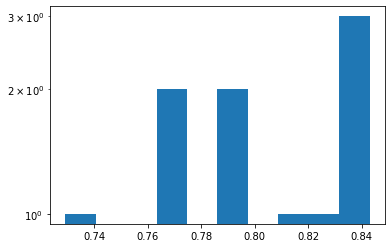

In [ ]:
dataset = test_dataset
all_ratios = np.zeros(len(list(dataset)))
i = 0
i90 = 0
for example in dataset:
  tinp = example[0]
  ttar = example[1]
  prediction = generator(tinp, training=True)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction
  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(pass_ratio)
  all_ratios[i] = pass_ratio
  i = i+1
  if(pass_ratio > 0.90):
    i90 = i90+1

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios))) 
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios)))
print("ratio > 90% " + str(float(i90)/float(i)))
plt.hist(all_ratios)
plt.yscale('log')